In [1]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

In [2]:
# Load the dataset
crops = pd.read_csv("Agri Project/soil_measures.csv")

In [3]:
# Descriptive Data analysis
crops.head()

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


In [4]:
# No null values in the dataset, ready for classification
crops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       2200 non-null   int64  
 1   P       2200 non-null   int64  
 2   K       2200 non-null   int64  
 3   ph      2200 non-null   float64
 4   crop    2200 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 86.1+ KB


In [5]:
crops.isna().sum().sort_values()

N       0
P       0
K       0
ph      0
crop    0
dtype: int64

In [6]:
# Distribution of data is reasonable, no need for further cleaning.
# The range of input variables are different, standard scaling will be applied to address this issue
crops.describe()

,N,P,K,ph
count,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,6.469480
std,36.917334,32.985883,50.647931,0.773938
min,0.000000,5.000000,5.000000,3.504752
25%,21.000000,28.000000,20.000000,5.971693
50%,37.000000,51.000000,32.000000,6.425045
75%,84.250000,68.000000,49.000000,6.923643
max,140.000000,145.000000,205.000000,9.935091


In [7]:
# There are 22 unique crops
crops['crop'].nunique()

22

In [8]:
# Crate X and y arrays
X = crops.drop('crop', axis = 1).values
y = crops['crop'].values

In [22]:
# Double check input variables
print(X)
print(y)

[[ 90.          42.          43.           6.50298529]
 [ 85.          58.          41.           7.03809636]
 [ 60.          55.          44.           7.84020714]
 ...
 [118.          33.          30.           6.36260785]
 [117.          32.          34.           6.75879255]
 [104.          18.          30.           6.77983261]]
['rice' 'rice' 'rice' ... 'coffee' 'coffee' 'coffee']


In [23]:
# Split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Scale input variables N, P, K and pH
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

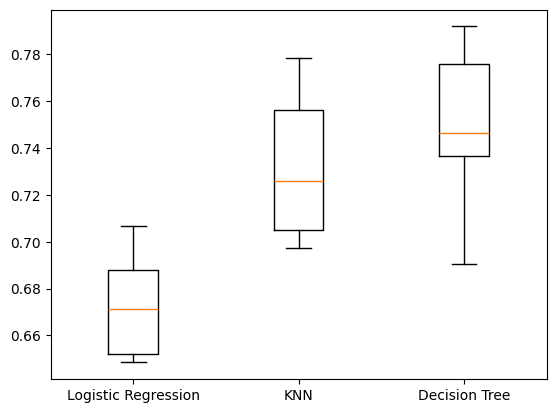

In [25]:
# Classification model selection: Logistice, KNN and Decision Tree
models = {"Logistic Regression": LogisticRegression(),
"KNN": KNeighborsClassifier(),
"Decision Tree": DecisionTreeClassifier()}
results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)
plt.boxplot(results, labels=models.keys())
plt.show()

In [26]:
# Decision Tree has the best cross-validation score on train sets, compare model accuracy on test sets
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    test_score = accuracy_score(y_test, y_pred)
    print("{} Test Set Accuracy: {}".format(name, test_score))
    print(classification_report(y_test, y_pred))

Logistic Regression Test Set Accuracy: 0.6590909090909091
              precision    recall  f1-score   support

       apple       0.88      0.30      0.45        23
      banana       1.00      1.00      1.00        21
   blackgram       0.76      0.65      0.70        20
    chickpea       1.00      0.77      0.87        26
     coconut       0.81      0.63      0.71        27
      coffee       0.76      0.76      0.76        17
      cotton       0.88      0.88      0.88        17
      grapes       0.45      0.93      0.60        14
        jute       0.50      0.48      0.49        23
 kidneybeans       0.45      0.65      0.53        20
      lentil       0.30      0.64      0.41        11
       maize       0.91      1.00      0.95        21
       mango       0.40      0.53      0.45        19
   mothbeans       0.60      0.25      0.35        24
    mungbean       0.67      0.74      0.70        19
   muskmelon       0.62      0.76      0.68        17
      orange       1.00

In [27]:
# Based on the accuracy score, choose the decision tree model for the classification problem
# Fine-tune the decision tree model with Grid Search hyperparameter tuning

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Choose a scoring metric
scoring = 'accuracy'

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=models["Decision Tree"], param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model
accuracy = best_model.score(X_test_scaled, y_test)

In [28]:
# After hyper-parameter tuning, the accuracy increased 0.02
print("Tuned Decision Tree Regression Parameters: {},\nAccuracy: {}".format(best_params, accuracy))

Tuned Decision Tree Regression Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2},
Accuracy: 0.7772727272727272


In [29]:
# Find feature importance using Decision Tress model: most important feature is K (potassium content)
# Get feature importances
importances = best_model.feature_importances_
# Map N, P, K, pH to feature #
feature_importance_associated = zip(crops.drop("crop", axis=1).columns, importances)

# Print feature importance along with column names
for feature, importance in feature_importance_associated:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: N, Importance: 0.23192780282975145
Feature: P, Importance: 0.26589834222971004
Feature: K, Importance: 0.3115496596054805
Feature: ph, Importance: 0.190624195335058


In [31]:
# Store in best_predictive_feature dictionary
best_predictive_feature = {crops.columns[np.argmax(importances)]: importances[np.argmax(importances)]}
best_predictive_feature

{'K': 0.3115496596054805}